Tutorial for optimization of a mechanism with 2-link main branch. 
Relative generator and multicriterial optimization. 

Last update 09.07.2024

In [2]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem, MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory, get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward, MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L,get_preset_by_index

Construct the graph manager for optimization. One can use functions of the GraphManager2L class or one of mechs from preset

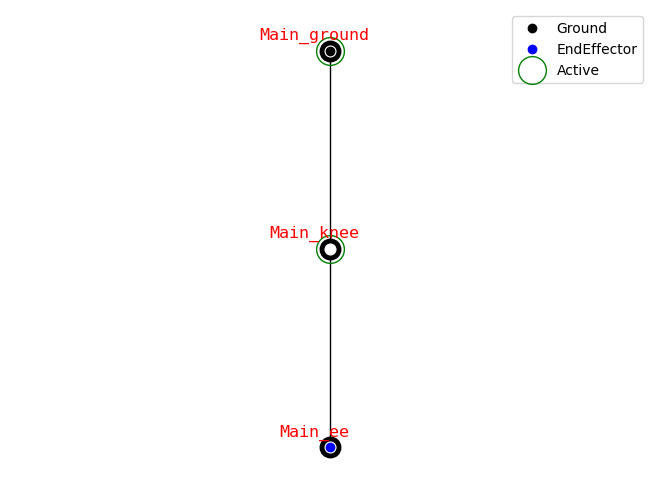

In [3]:
gm = get_preset_by_index(-1)
# get the values for central graph and get the actual graph using these values 
center = gm.generate_central_from_mutation_range()
graph = gm.get_graph(center)
draw_joint_point(graph)

In [4]:
# alternative way to setup graph manager
gm = GraphManager2L()
gm.reset()
gm.build_main(0.4, fully_actuated=True)
gm.set_mutation_ranges() # that function creates ranges from the , it must be called before any graph generation

Graph manager provides possible joint point movements and can generate graph from the provided range.
There are auxiliary functions for generating central and random graphs. The vector for graph generation can be mutated to get the required graph.

{'Main_knee_2': (-0.30000000000000004, -0.1)}
[-0.3]


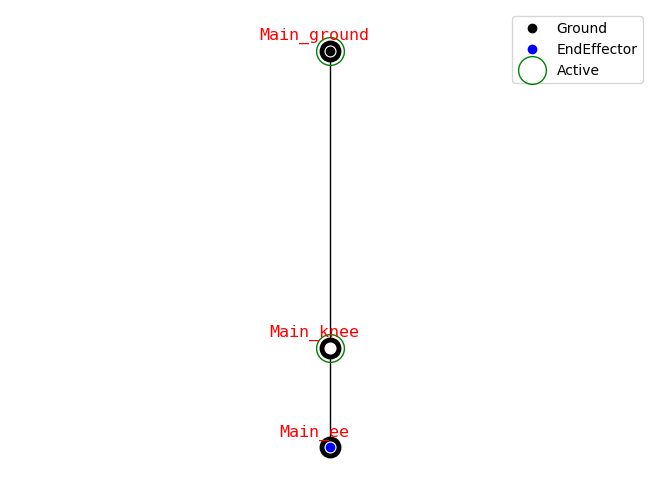

In [5]:
print(gm.mutation_ranges)
center = gm.generate_central_from_mutation_range()
center[0] = -0.3
print(center)
graph = gm.get_graph(center)
draw_joint_point(graph)

The core of the optimization is the builder class that can transform JointPoint graph into the URDF description of a robot. The description includes actuation and constrains to form closed kinematic chains.
The builder object requires additional information for building the model. In this tutorial the parameters match the real robot parameters.  

In [ ]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

Implemented Kinematic simulation is trajectory based, therefore one must define trajectories
Trajectory is a set of 6-dimensional points that specify position and rotation of EE frame.

In [6]:
workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))

ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50))

central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.075, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, -0.09, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, 0.09, 50))

Kinematic simulation is carried out by the CriteriaAggregator object. Its main function is to perform a simulation for a given trajectory and calculate predefined characteristics along this trajectory.

The characteristics to be calculated have to be implemented using the ComputeInterface and aggregated in the dictionaries of the form Name -> Class derived from the ComputeInterface  

Currently there are two types of characteristics:  
1) either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory (dict_trajectory_criteria)
2) calculated for each point on the trajectory (dict_point_criteria)

In [7]:
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}

dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the characteristics for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

array([[ 0.09      ,  0.        , -0.32      ,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.31867347,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.31734694,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.31602041,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.31469388,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.31336735,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.31204082,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.31071429,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.30938776,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.30806122,  0.        ,  0.        ,
         0.        ],
       [ 0.09      ,  0.        , -0.30673469,  0.

Current optimization process has two steps. Our criteria can be calculated only if a mechanism can reach all points at the trajectory.  
The first step is to check the reachability using PositioningConstrain. If any point is unreachable the mech get negative reward and other rewards are not calculated. That mechanism work instead of constrains in the optimization space. The reachability trajectory can be different from the actual 



In [ ]:
# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
min_velocity = MinManipulabilityReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

min_force = MinForceReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(
    error_calculator=error_calculator, points=[workspace_trajectory])


# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)

reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')